In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import display


# ---------- 1. 生成一个示例数据集 ----------
np.random.seed(42)
n = 5000
weather_choices = ["Clear", "Clouds", "Rain", "Snow", "Fog", "Thunderstorm", "Drizzle", "Haze"]
df = pd.DataFrame({
    "weather_main": np.random.choice(weather_choices, size=n, p=[0.25,0.2,0.18,0.12,0.1,0.05,0.05,0.05]),
    "temp": np.random.normal(loc=20, scale=8, size=n).round(1),
})

# 让不同天气对 traffic_volume 有不同“真实”影响
weather_effect = {
    "Clear": 1500,
    "Clouds": 1200,
    "Rain": -500,
    "Snow": -800,
    "Fog": -300,
    "Thunderstorm": -700,
    "Drizzle": -200,
    "Haze": -100,
}

base_volume = 3000
df["traffic_volume"] = (
    base_volume
    + df["weather_main"].map(weather_effect)
    + 20 * (df["temp"] - 20)        # 温度偏离 20℃ 正相关
    + np.random.normal(scale=300, size=n)  # 噪声
).round().astype(int)

# ---------- 2. Target Encoding 函数 ----------
def target_encode(train_series, target_series, test_series, n_splits=5, alpha=10):
    """返回训练集和测试集经过目标编码的新特征 Series"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = target_series.mean()
    encoded_train = pd.Series(index=train_series.index, dtype=float)

    for tr_idx, val_idx in kf.split(train_series):
        tr_cat = train_series.iloc[tr_idx]
        tr_tgt = target_series.iloc[tr_idx]
        means  = tr_tgt.groupby(tr_cat).mean()
        counts = tr_cat.value_counts()
        smooth = (means * counts + global_mean * alpha) / (counts + alpha)
        encoded_train.iloc[val_idx] = train_series.iloc[val_idx].map(smooth)

    # 映射测试集：用训练整体的平滑值
    counts_full = train_series.value_counts()
    means_full  = target_series.groupby(train_series).mean()
    smooth_full = (means_full * counts_full + global_mean * alpha) / (counts_full + alpha)
    encoded_test = test_series.map(smooth_full).fillna(global_mean)

    return encoded_train, encoded_test

# ---------- 3. 评估不同 alpha ----------
alphas = [1, 5, 10,20,40, 50]
results = []

X_other = ["temp"]  # 连续变量直接使用
y_col = "traffic_volume"

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

for alpha in alphas:
    te_train, te_test = target_encode(
        train_df["weather_main"], train_df[y_col],
        test_df["weather_main"], n_splits=5, alpha=alpha
    )
    train_df[f"weather_te_{alpha}"] = te_train
    test_df[f"weather_te_{alpha}"] = te_test

    model = GradientBoostingRegressor(random_state=42)
    features = X_other + [f"weather_te_{alpha}"]
    model.fit(train_df[features], train_df[y_col])
    pred = model.predict(test_df[features])

    r2 = r2_score(test_df[y_col], pred)
    rmse = np.sqrt(mean_squared_error(test_df[y_col], pred))
    results.append({"alpha": alpha, "R2": round(r2, 4), "RMSE": round(rmse, 1)})

results_df = pd.DataFrame(results).sort_values("alpha").reset_index(drop=True)
display(results_df)


,alpha,R2,RMSE
0,1,0.9164,294.0
1,5,0.9165,293.8
2,10,0.9167,293.5
3,20,0.9164,294.1
4,40,0.9163,294.2
5,50,0.9077,309.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15384\410254812.py:26: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


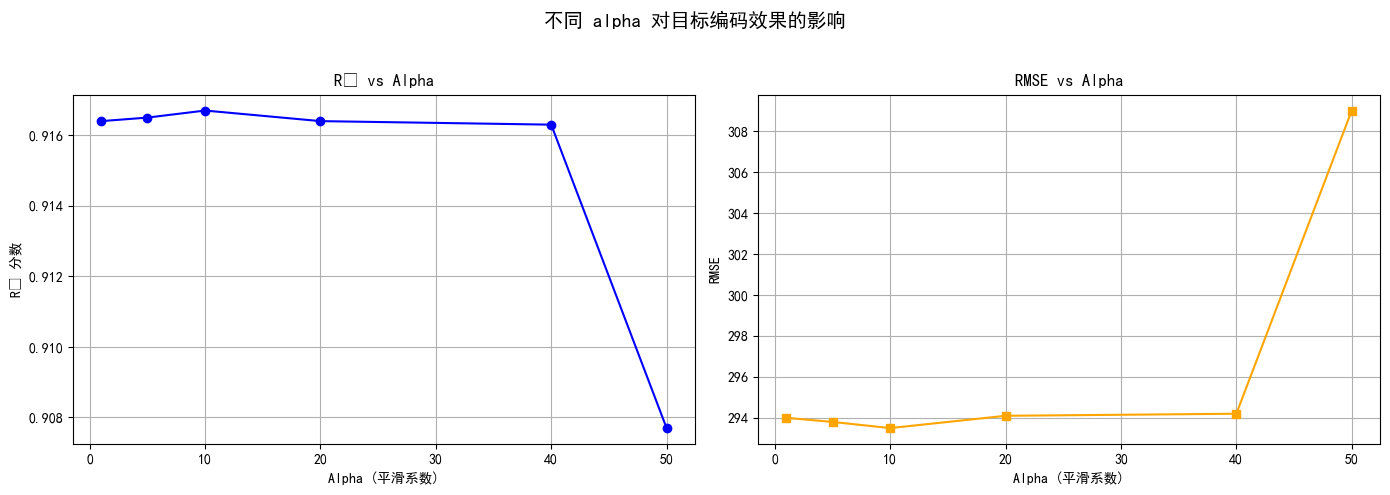

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']        # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  
# 排序，确保 x 轴从小到大
results_df = results_df.sort_values("alpha").reset_index(drop=True)

# 创建画布和两个子图（1行2列）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ---- 左图：R² 分数 ----
ax1.plot(results_df["alpha"], results_df["R2"], marker='o', color='blue')
ax1.set_title("R² vs Alpha")
ax1.set_xlabel("Alpha (平滑系数)")
ax1.set_ylabel("R² 分数")
ax1.grid(True)

# ---- 右图：RMSE ----
ax2.plot(results_df["alpha"], results_df["RMSE"], marker='s', color='orange')
ax2.set_title("RMSE vs Alpha")
ax2.set_xlabel("Alpha (平滑系数)")
ax2.set_ylabel("RMSE")
ax2.grid(True)

# 总体标题 + 调整布局
fig.suptitle("不同 alpha 对目标编码效果的影响", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from category_encoders import TargetEncoder, LeaveOneOutEncoder

# 1. 模拟数据生成（可换成你的数据）
np.random.seed(42)
n = 5000
weather_choices = ["Clear", "Clouds", "Rain", "Snow", "Fog", "Thunderstorm", "Drizzle", "Haze"]
df = pd.DataFrame({
    "weather_main": np.random.choice(weather_choices, size=n, p=[0.25,0.2,0.18,0.12,0.1,0.05,0.05,0.05]),
    "temp": np.random.normal(loc=20, scale=8, size=n).round(1),
})
weather_effect = {
    "Clear": 1500, "Clouds": 1200, "Rain": -500, "Snow": -800,
    "Fog": -300, "Thunderstorm": -700, "Drizzle": -200, "Haze": -100
}
df["traffic_volume"] = (
    3000 + df["weather_main"].map(weather_effect)
    + 20 * (df["temp"] - 20)
    + np.random.normal(scale=300, size=n)
).round().astype(int)

# 2. 拆分数据
X = df[["weather_main", "temp"]]
y = df["traffic_volume"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 三种编码器
encoders = {
    "OneHot": OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "Target": TargetEncoder(cols=["weather_main"], smoothing=10),
    "LeaveOneOut": LeaveOneOutEncoder(cols=["weather_main"], sigma=0.1)
}

results = []

# 4. 建模 + 评估
for name, encoder in encoders.items():
    if name == "OneHot":
        preprocessor = ColumnTransformer([
            ("cat", encoder, ["weather_main"]),
            ("num", "passthrough", ["temp"])
        ])
    else:
        preprocessor = Pipeline([
            ("encode", encoder)
        ])

    model = Pipeline([
        ("pre", preprocessor),
        ("reg", GradientBoostingRegressor(random_state=42))
    ])

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"编码方式": name, "R²": round(r2, 4), "RMSE": round(rmse, 1)})

# 5. 输出对比结果
compare_df = pd.DataFrame(results)
print(compare_df)


          编码方式      R²   RMSE
0       OneHot  0.9166  293.7
1       Target  0.9167  293.5
2  LeaveOneOut  0.9021  318.2
